In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image



In [4]:
class HarrisDetector():


    def convolve(self, image, kernel, padding=1, strides=1):
        kernel_height, kernel_width = kernel.shape

        pad_height = kernel_height // 2
        pad_width = kernel_width // 2

        image_padded = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

        x_kern_shape, y_kern_shape = kernel.shape
        x_img_shape, y_img_shape = image.shape

        x_output = (x_img_shape - x_kern_shape + 2 * padding) // strides + 1
        y_output = (y_img_shape - y_kern_shape + 2 * padding) // strides + 1
        output = np.zeros((x_output, y_output))

        for y in range(0, y_img_shape - y_kern_shape + 1, strides):
            for x in range(0, x_img_shape - x_kern_shape + 1, strides):
                output[x // strides, y // strides] = np.sum(
                    image_padded[x:x + x_kern_shape, y:y + y_kern_shape] * kernel)
        return output

    def gaussian_blur(self, image, kernel_size=3):
        sigma = 0.5 * ((kernel_size - 1) * 0.5 - 1) + 0.8
        kernel = np.fromfunction(lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * np.exp(
            -((x - kernel_size // 2) ** 2 + (y - kernel_size // 2) ** 2) / (2 * sigma ** 2)), (kernel_size, kernel_size))
        kernel /= np.sum(kernel)

        blurred_image = np.zeros_like(image)
        for i in range(image.shape[0] - kernel_size + 1):
            for j in range(image.shape[1] - kernel_size + 1):
                blurred_image[i:i + kernel_size, j:j + kernel_size] = np.sum(
                    image[i:i + kernel_size, j:j + kernel_size] * kernel)
        return blurred_image

    def non_maximum_suppression(self, R, threshold, neighborhood_size=3):
        local_maxima = np.zeros_like(R, dtype=np.uint8)
        for i in range(neighborhood_size, R.shape[0] - neighborhood_size):
            for j in range(neighborhood_size, R.shape[1] - neighborhood_size):
                if R[i, j] > threshold and R[i, j] == np.max(
                        R[i - neighborhood_size:i + neighborhood_size + 1, j - neighborhood_size:j + neighborhood_size + 1]):
                    local_maxima[i, j] = 255
        return local_maxima

    def harris_corner_detector(self, image, blocksize, ksize, k):
        sobelx = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

        sobely = np.array([[-1, -2, -1],
                           [0, 0, 0],
                           [1, 2, 1]])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        Ix = self.convolve(image, sobelx)
        Iy = self.convolve(image, sobely)
        Ixy = Ix * Iy
        Ixx = Ix ** 2
        Iyy = Iy ** 2
        Sxx = self.gaussian_blur(Ixx, kernel_size=ksize)
        Syy = self.gaussian_blur(Iyy, kernel_size=ksize)
        Sxy = self.gaussian_blur(Ixy, kernel_size=ksize)
        det_M = Sxx * Syy - Sxy ** 2
        trace_M = Sxx + Syy
        R = (det_M) - k * (trace_M) ** 2
        corner_map = self.non_maximum_suppression(R, 0.01 * np.max(R), blocksize)
        return corner_map 

    def harris_corner_detection_cv(self,image, block_size, ksize, k):
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        
        corner_response = cv2.cornerHarris(image, blockSize=block_size, ksize=ksize, k=k)

       
        threshold = 0.01 * corner_response.max()  
        corner_points = np.zeros_like(image)
        corner_points[corner_response > threshold] = 255

        kernel = np.ones((2,2),np.uint8)  
        corner_points_dilated = cv2.dilate(corner_points, kernel, iterations=1)

        output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        output_image[corner_points_dilated == 255] = [0, 0, 255] 
        output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        
        return output_image_rgb
    

    def display(self, corner_map, image):
        corner_mask = np.uint8(corner_map == 255)
        
        kernel = np.ones((5, 5), np.uint8) 
        dilated_corners = cv2.dilate(corner_mask, kernel, iterations=1)
        display_img = image.copy()
        
        display_img[dilated_corners > 0] = [0, 0, 255] 

        
        display_img_rgb = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
        
        return display_img_rgb



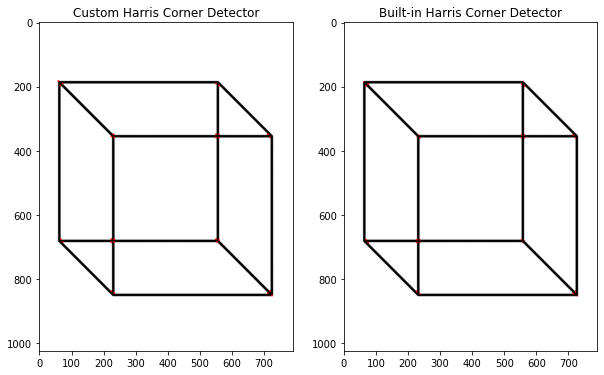

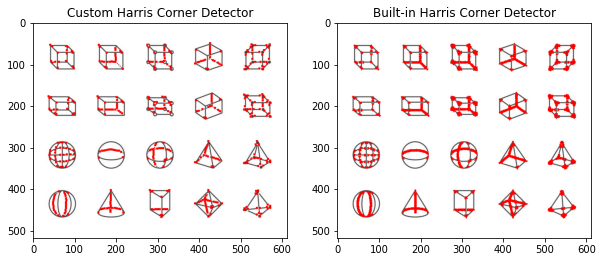

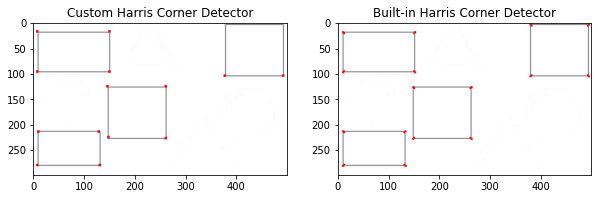

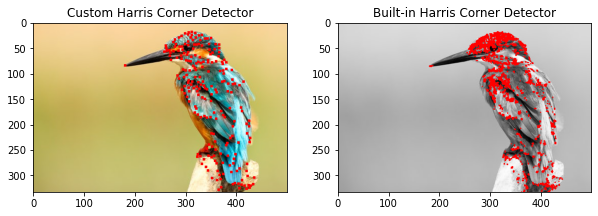

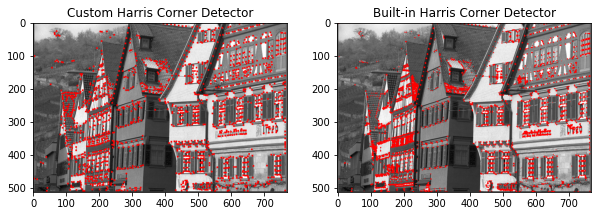

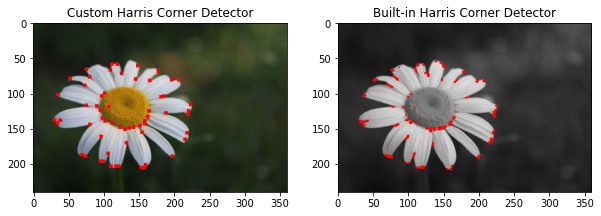

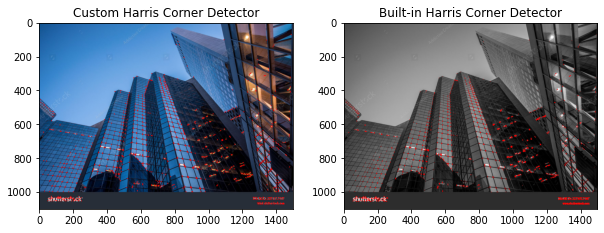

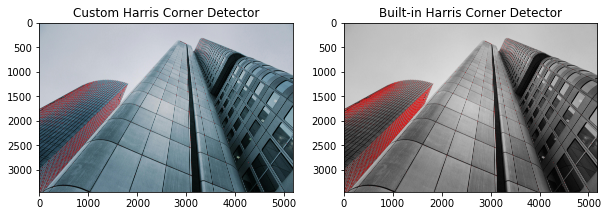

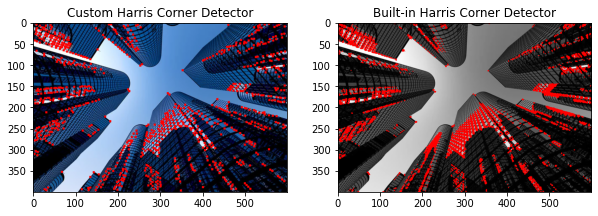

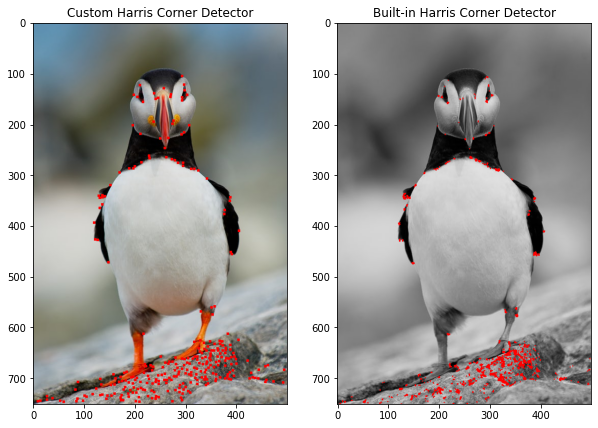

In [5]:
block_size = 3
ksize = 3
k = 0.04
image_folder = os.listdir('Question 1')

for i in range(len(image_folder)):
    img_path = os.path.join('Question 1', image_folder[i])
    if os.path.splitext(img_path)[1].lower() == ".gif":
        gif_image = Image.open(img_path)
        first_frame = gif_image.convert("RGB")
        test_img = np.array(first_frame)
        

    else:
        test_img = cv2.imread(img_path)

    HD = HarrisDetector()
    corner_map = HD.harris_corner_detector(test_img,blocksize=block_size,ksize=ksize, k=k)
    custom_corners_image = HD.display(corner_map,test_img)
    built_in_corners_image = HD.harris_corner_detection_cv(test_img, block_size, ksize, k)
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(custom_corners_image)
    plt.title('Custom Harris Corner Detector')
    plt.subplot(122)
    plt.imshow(built_in_corners_image)
    plt.title('Built-in Harris Corner Detector')
    plt.show()
    


